<a href="https://colab.research.google.com/github/Ritanjit/IITg_Internship_Assignments/blob/main/DogsCats_ResNet_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dog vs Cat Classification using Pre-trained ResNet-101 Model**


> *This project implements the ResNet-101 modeL with the help of pytorch to classify images of dogs and cats.*

> *Dataset used: Microsoft Cats and Dogs Dataset from Kaggle*


# Imports and Setup

In [ ]:
# Install required packages
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# Download the dataset (from kaggle)
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

# Unzip the dataset
!unzip -q kagglecatsanddogs_5340.zip -d data

--2025-06-27 04:00:24--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.176.164, 2600:1406:5400:2ae::317f, 2600:1406:5400:2ac::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.176.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   115MB/s    in 6.4s    

2025-06-27 04:00:31 (123 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



# Preprocessing

In [ ]:
# Remove zero-byte (corrupted) files
for path, _, files in os.walk('data/PetImages'):
    for fname in files:
        fp = os.path.join(path, fname)
        if os.path.getsize(fp) == 0:
            os.remove(fp)
            print(f"[Cell 2] Removed corrupted file: {fp}")

[Cell 2] Removed corrupted file: data/PetImages/Cat/666.jpg
[Cell 2] Removed corrupted file: data/PetImages/Dog/11702.jpg


In [ ]:
# Create train and validation directories
data_dir = 'data/PetImages' # Define data_dir here
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

os.makedirs(os.path.join(train_dir, 'Cat'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Dog'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Cat'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Dog'), exist_ok=True)

# Move images to train and validation directories (simplified for demonstration)
# In a real scenario, you would want to split the data more carefully
def move_images(source_dir, train_split=0.8):
    for class_name in ['Cat', 'Dog']:
        class_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        np.random.shuffle(images) # Shuffle images
        train_count = int(len(images) * train_split)

        for i, image_name in enumerate(images):
            src_path = os.path.join(class_path, image_name)
            if i < train_count:
                dest_path = os.path.join(train_dir, class_name, image_name)
            else:
                dest_path = os.path.join(val_dir, class_name, image_name)
            try:
              os.rename(src_path, dest_path)
            except FileNotFoundError:
              print(f"Warning: Could not move {src_path}. It might have been corrupted or removed.")
            except Exception as e:
              print(f"An error occurred while moving {src_path}: {e}")


move_images(data_dir)

print("Data split into train and validation sets.")

Data split into train and validation sets.


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/PetImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")

Class names: ['Cat', 'Dog']
Train dataset size: 19998
Validation dataset size: 5000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Model Training

In [ ]:
# Load ResNet101 model pre-trained on ImageNet-1K dataset
model_ft = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Modify the final fully connected layer to match the number of classes (2 classese - Cat & Dog)
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device (GPU)
model_ft = model_ft.to(device)

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Stochastic Gradient Descent with momentum)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs to help in fine-tuning the model by reducing the learning rate over time.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("Model, criterion, optimizer, and scheduler defined.")

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 189MB/s]


Model, criterion, optimizer, and scheduler defined.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero parameter gradients
                optimizer.zero_grad()

                # forward - track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward - optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Start training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.1015 Acc: 0.9614


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0222 Acc: 0.9928

Epoch 1/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0661 Acc: 0.9734


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0224 Acc: 0.9928

Epoch 2/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0586 Acc: 0.9757


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0197 Acc: 0.9940

Epoch 3/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0518 Acc: 0.9784


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0183 Acc: 0.9942

Epoch 4/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0462 Acc: 0.9796


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0185 Acc: 0.9954

Epoch 5/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0476 Acc: 0.9798


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0197 Acc: 0.9952

Epoch 6/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0443 Acc: 0.9823


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0201 Acc: 0.9936

Epoch 7/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0366 Acc: 0.9852


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0191 Acc: 0.9948

Epoch 8/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0353 Acc: 0.9859


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0184 Acc: 0.9952

Epoch 9/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0322 Acc: 0.9873


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0180 Acc: 0.9950

Training complete in 59m 31s
Best val Acc: 0.9954


# Evalutation and Save Model

In [ ]:
# Evaluate the model
def evaluate_model(model, dataloader, dataset_size, class_names):
    model.eval()  # Set model to evaluate mode
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / dataset_size

    print(f'Evaluation Accuracy: {epoch_acc:.4f}')
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

evaluate_model(model_ft, dataloaders['val'], dataset_sizes['val'], class_names)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Evaluation Accuracy: 0.9954
Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      1.00      1.00      2500
         Dog       1.00      0.99      1.00      2500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Confusion Matrix:
[[2491    9]
 [  14 2486]]


In [ ]:
# Save the trained model
model_save_path = 'cats_and_dogs_resnet101.pth'
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'class_names': class_names  # Save class names along with the model
}, model_save_path)

print(f"\nTrained model saved locally to {model_save_path}")

# Upload to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import shutil

# Define destination path in Google Drive
drive_model_path = '/content/drive/MyDrive/' + model_save_path

# Copy the model to Google Drive
shutil.copy(model_save_path, drive_model_path)

print(f"\nModel uploaded to Google Drive at: {drive_model_path}")
print("Model saved with:")
print(f"- Model state dictionary")
print(f"- Class names: {class_names}")


Trained model saved locally to cats_and_dogs_resnet101.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Model uploaded to Google Drive at: /content/drive/MyDrive/cats_and_dogs_resnet101.pth
Model saved with:
- Model state dictionary
- Class names: ['Cat', 'Dog']


# Model Testing


Processing images in folder: /content/drive/MyDrive/ML


Predicting for image: 1.jpg
Prediction: Dog



Predicting for image: 2.jpg
Prediction: Dog



Predicting for image: 3.jpg
Prediction: Dog



Predicting for image: 4.jpg
Prediction: Dog



Predicting for image: 5.jpg
Prediction: Cat



Predicting for image: 6.jpg
Prediction: Cat



Predicting for image: 7.jpg
Prediction: Cat



Predicting for image: 8.jpg
Prediction: Cat




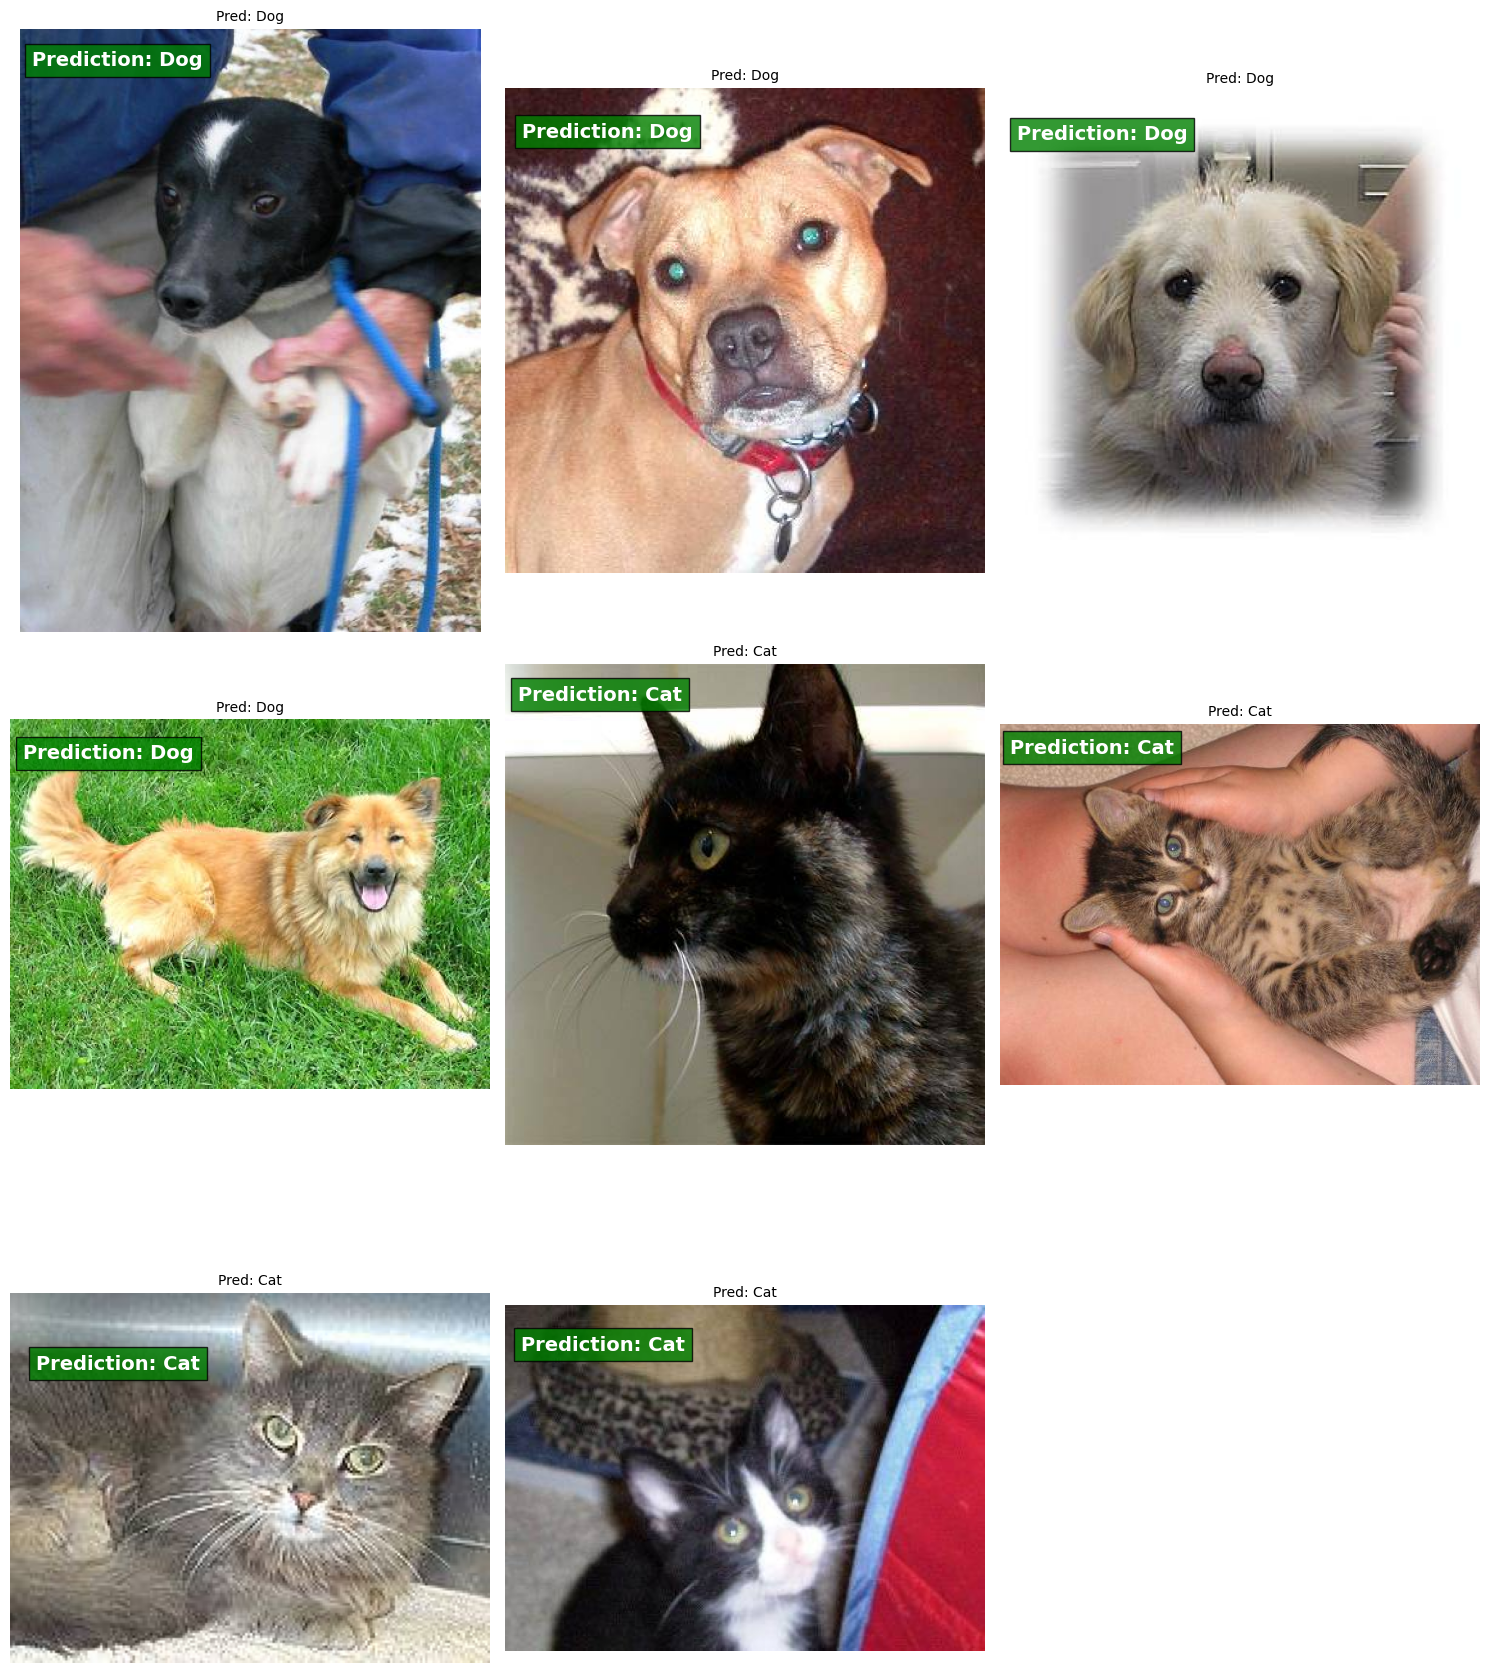

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

def predict_images_in_folder(model, folder_path, transform, class_names, device, images_per_row=3):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    print(f"\nProcessing images in folder: {folder_path}\n")

    # Filter and sort image files
    image_files = [f for f in sorted(os.listdir(folder_path))
                 if os.path.isfile(os.path.join(folder_path, f))
                 and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Calculate grid size
    num_images = len(image_files)
    num_rows = math.ceil(num_images / images_per_row)

    # Create figure for grid display
    plt.figure(figsize=(15, 6*num_rows))

    for i, filename in enumerate(image_files, 1):
        image_path = os.path.join(folder_path, filename)
        print(f"\nPredicting for image: {filename}")
        predicted_class = predict_image_and_show(model, image_path, transform, class_names, device, show_image=False)

        if predicted_class:
            try:
                # Add subplot for this image
                plt.subplot(num_rows, images_per_row, i)
                image = Image.open(image_path).convert('RGB')
                plt.imshow(image)
                plt.title(f"Pred: {predicted_class}", fontsize=10)
                plt.axis('off')

                # Add prediction label
                plt.text(10, 30, f"Prediction: {predicted_class}",
                        bbox=dict(facecolor='green', alpha=0.8, pad=5),  # Increased padding
                        fontsize=14,  # Increased from 8 to 14
                        color='white',
                        weight='bold')  # Added bold

                print(f"Prediction: {predicted_class}")
            except Exception as e:
                print(f"Error displaying image {filename}: {e}")
        else:
            print(f"Could not predict for image: {filename}")

        print("\n" + "="*50 + "\n")  # Add a separator

    plt.tight_layout()
    plt.show()

# Example usage
folder_to_predict = '/content/drive/MyDrive/ML'
validation_transform = data_transforms['val']
predict_images_in_folder(model_ft, folder_to_predict, validation_transform, class_names, device, images_per_row=3)